# Richardson-Lucy Deconvolution

---

This notebook demonstrates the [Richardson-Lucy](https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution)
method for deconvolution.

---


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, fftconvolve
from astropy.convolution import convolve_fft
from skimage.restoration import richardson_lucy
from sf_tools.image.quality import nmse

In [2]:
def convolve(image, kernel, rot=False):
    
    if rot:
        kernel = np.rot90(kernel, 2)
        
#     return fftconvolve(image, kernel, 'same')
    
    return convolve_fft(image, kernel, boundary='wrap', crop=False,
                        nan_treatment='fill', normalize_kernel=False)

In [3]:
def RL_Deconvolve(image, psf, n_iter=100):
    
    x_hat = 0.5 * np.ones(image.shape)
    
    for i in range(n_iter):
        
        x_hat *= convolve(image / convolve(x_hat, psf), psf, rot=True)
        
    return x_hat

In [4]:
x = np.load('/Users/farrens/Documents/Projects/PSF/data/clean_data/deep_galaxy_cube_10000_norm.npy')[8]
H = np.load('/Users/farrens/Documents/Projects/PSF/data/psf/euclid_psf_wl0.6_norm.npy')[0]

In [5]:
sigma = 0.0001

y = convolve(x, H) + np.random.randn(*x.shape) * sigma

In [6]:
print('SNR = {}'.format(np.std(convolve(x, H)) / sigma))

SNR = 23.780565153167288


In [13]:
n_iter = 10

x_skrl = richardson_lucy(y, H, iterations=n_iter)
x_rl = RL_Deconvolve(y, H, n_iter=n_iter)

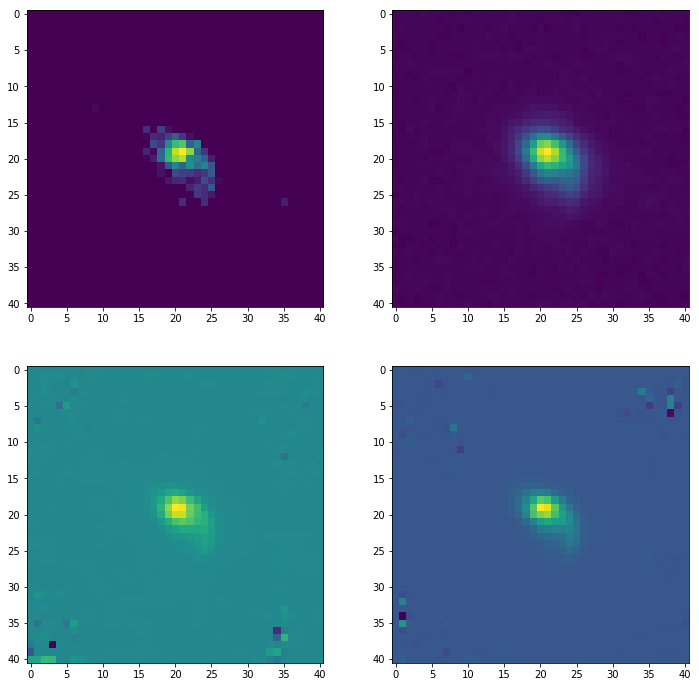

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax[0, 0].imshow(x)
ax[0, 1].imshow(y)
ax[1, 0].imshow(x_skrl)
ax[1, 1].imshow(x_rl)

plt.show()

In [15]:
print('NMSE(x_skrl, x_rl) = {}'.format(nmse(x_skrl, x_rl)))
print('NMSE(x, x_skrl) = {}'.format(nmse(x, x_skrl)))
print('NMSE(x, x_rl) = {}'.format(nmse(x, x_rl)))

NMSE(x_skrl, x_rl) = 0.2901854708027055
NMSE(x, x_skrl) = 0.26828996491892526
NMSE(x, x_rl) = 0.12956308267203429
